# Twitter US Airline Sentiment
## Analyze how travelers in February 2015 expressed their feelings on Twitter


## 1.Motivation:


so many new advancements has been emerging for Deep Learning in NLP during the last couple of years. two of the major break throughs are the ability to apply transfer learning for NLP and  the invent of Transformers.  the traditional approaches to undrestand the semantics and syntactical meaning of words and sentences through word embeddings are not capable of achieving desired preformance when it comes to different down stream tasks such as sentiment analysis, question-answeing, machine translation, named entity recognition and etc. In practice, natural language data can come in a variety of formats (tweets, blog posts, reviews etc.), and hence, a model trained for a particular language task does not generalize well to new data. moreover, many natural language applications do not come with an abundance of labeled examples, and human annotation can get very expensive as the datasets get larger.

here we can take advantage of an already proved to work approach in Computer Vision: Transfer Leraning is going to save us all. ImageNet’s impact on the course of machine learning research can hardly be overstated. The dataset was originally published in 2009 and quickly evolved into the ImageNet Large Scale Visual Recognition Challenge (ILSVRC). In 2012, the deep neural network submitted by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton performed 41% better than the next best competitor, demonstrating that deep learning was a viable strategy for machine learning and arguably triggering the explosion of deep learning in ML research. ( [Source](http://ruder.io/nlp-imagenet/)).

the same approach can be applied in NLP. Howard and Ruder (authors of the paper: Universal Language Model Fine-tuning for Text Classification) propose a bi-LSTM model that is trained on a general language modeling (LM) task and then fine tuned on text classification. This would, in principle, perform well because the model would be able to use its knowledge of the semantics of language acquired from the generative pre-training. Ideally, this transfer can be done from any source task S to a target task T. The authors use LM as the source task because ([Source](https://medium.com/explorations-in-language-and-learning/transfer-learning-in-nlp-2d09c3dfaeb6)):


1.   it is able to capture long-term dependencies in language
2.   it effectively incorporates hierarchical relations
3.   it can help the model learn sentiments
4.   large data corpus is easily available for LM


**by end of this project, we can answer if applying transfer learning through using a large pre trained model can help us achieve reasonable performance and how our approach generalizes to specific down-streat tasks sucha as classisification of Tweets in this case. **

## Implementation

we are going to use the pre trained model in Universal Language Model Fine-tuning for Text Classification (ULMFiT). link to the [Paper](https://arxiv.org/pdf/1801.06146.pdf). this model was trained on Wikitext-103 consisting of 28,595 prepro-cessed Wikipedia articles and 103 million words dataset. let's have a look at the overall architecture of the model:

![Architecture](https://drive.google.com/uc?id=1xtBwM8lJ4SO5CUsiiTse-G25CTaZ_Aw6)


as clearly depicted by the image, we can see that it's a 3-layer bi-LSTM network. the overall idea is that at the first stage, the general-domain Lannguage Model (LM) is trained. next the LM on the target task is fine-tuned, and finally the down stream task, here classification, is fine-tuned. there are more concepts like DISCR and STLR  in the explaination of the image that I will discuss shortly.

**we are going to use a dataset from kaggle. this dataset contains the Tweets about American Airlines in Feb 2015 and it shows how people expressed their feelings about the servise they received. the tweets are categorized in 3 different sentiments: Positive, Negative, and Neutral. lets load the data and do some EDA to get a better understanding about the dataset. but before going further, there are some pre requisites in order to run this project. the UMLFiT model is available through fastai.text library. so we need to install pytorch first since fastai is built on top of pytorch and then we can install fastai. **


In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 29kB/s 


In [0]:
!pip install fastai

    100% |████████████████████████████████| 17.3MB 2.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built wrapt
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
tensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 1.12.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: wrapt 1.11.1
    Uninstalling wrapt-1.11.1:
      Successfully uninstalled wrapt-1.11.1


In [0]:
# in order to have access to the dataset on kaggle, we must install the api here as well:
!pip install kaggle

In [0]:
# we are importing the required libraries and in order to access the dataset on kaggle, we must get an api key.
# you can get the api key by registering an account on kaggle. we are going to upload the api key
# which is a jason file into our working directory

from fastai import *
from fastai.text import *
from fastai.core import *
import pandas as pd
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [0]:
# here we download the dataset
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.68M [00:00<?, ?B/s]
100% 2.68M/2.68M [00:00<00:00, 90.1MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json


In [0]:
# the downloaded dataset is in zip format so we unzip it
!ls

sample_data  twitter-airline-sentiment.zip


In [0]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [0]:
!ls

database.sqlite  sample_data  Tweets.csv  twitter-airline-sentiment.zip


In [0]:
# let's have a quick look at the first few lines of the data
data = pd.read_csv('Tweets.csv', encoding='utf-8')
data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
# the dataset has 14640 rows and 15 columns
print(data.shape)

(14640, 15)


Text(0, 0.5, 'No. of Tweets')

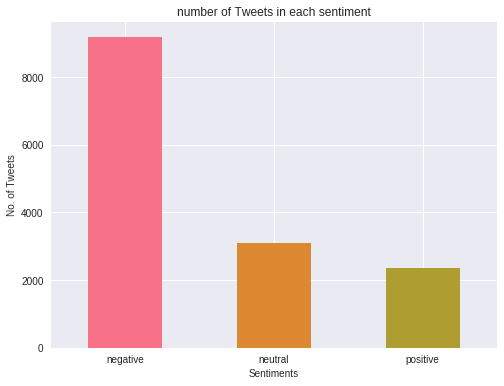

In [0]:
# lets import seaborn and matplotlib to do some visulaizations:

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

colors=sns.color_palette("husl", 10)
pd.Series(data["airline_sentiment"]).value_counts().plot(kind = "bar",
          color=colors,figsize=(8,6),rot=0, title = "number of Tweets in each sentiment")
plt.xlabel('Sentiments', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

so yeah, people are not very satisfied with the service they receive from those Airlines.

Text(0, 0.5, 'No. of Tweets')

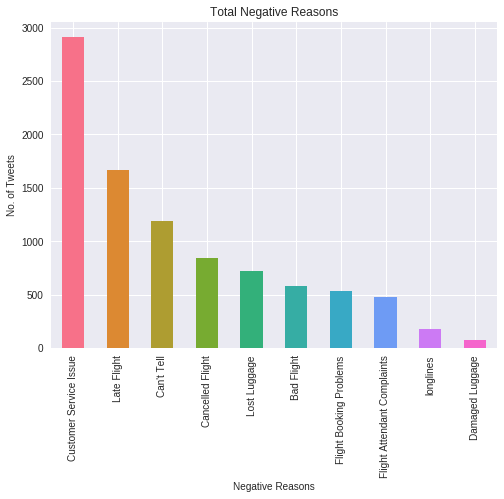

In [0]:
#  and let's see what the reasons are for negative sentiment

color=sns.color_palette("husl", 10)
pd.Series(data["negativereason"]).value_counts().plot(kind = "bar",
          color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

Customer Service Issues, yup, you guessed it right.

In [0]:
# so we only need two columns to work with:

new_data = data[['airline_sentiment', 'text']]
new_data.tail(10)

,airline_sentiment,text
14630,positive,@AmericanAir Thanks! He is.
14631,negative,@AmericanAir thx for nothing on getting us out...
14632,neutral,"“@AmericanAir: @TilleyMonsta George, that does..."
14633,negative,@AmericanAir my flight was Cancelled Flightled...
14634,negative,@AmericanAir right on cue with the delays👌
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."
14639,neutral,@AmericanAir we have 8 ppl so we need 2 know h...


In [0]:
# let's do just a little bit of data cleaning:
# we are going to remove all the mentions at the beginning of each tweet since they have no role in sentiment
# next, we will remove all the emojis and rename the column 'airline_sentiment'

import re

def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

new_data.text = new_data.text.apply(remove_mentions)
new_data['text'] = new_data['text'].apply((lambda x: re.sub('[^a-zA-Z0-9,;:!?.\s]','',x)))
new_data.columns = ['label', 'text']
new_data.tail(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,label,text
14630,positive,Thanks! He is.
14631,negative,thx for nothing on getting us out of the coun...
14632,neutral,": George, that doesnt look good. Please follo..."
14633,negative,"my flight was Cancelled Flightled, leaving to..."
14634,negative,right on cue with the delays
14635,positive,thank you we got on a different flight to Chi...
14636,negative,leaving over 20 minutes Late Flight. No warni...
14637,neutral,Please bring American Airlines to BlackBerry10
14638,negative,"you have my money, you change my flight, and ..."
14639,neutral,we have 8 ppl so we need 2 know how many seat...


In [0]:
# we are going to convert the final df into a csv file since we will load the data from csv
new_data.to_csv('texts.csv', index=False)
!mkdir ripo

In [0]:
!mv texts.csv /content/ripo

In [0]:
# assigning the path
path = Path('ripo')

**Preprocessing the data for LM fine-tuning**

the TextLMDataBunch class creates a TextDataBunch suitable for training a language model. All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

the TextClasDataBunch class creates a TextDataBunch suitable for training an RNN classifier.

[Source](https://docs.fast.ai/text.data.html#TextLMDataBunch)




In [0]:
# here we build our DataBunches for LM fine-tuning and classification

# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
# we save a pickled copy of our TextDataBunches
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
# we load the data
data_lm = load_data(path, fname='data_lm_export.pkl')
data_clas = load_data(path, fname='data_clas_export.pkl', bs=16)

There are three important ideas in ULMFiT that makes it quite amazing [Source](https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb): 


**1.  Discriminative Fine-tuning**

>From the ULMFit paper, each layer of the model captures different types of information. Hence, it makes sense to fine-tune each layer differently, and this is done in ULMFit after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer.


**2.   1-cycle learning rate policy**

> It is a modification of the [cyclical learning rate policy,](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFit implementation, this 1-cycle policy has been tweaked and is referred to as slanted triangular learning rate.

![Image](https://drive.google.com/uc?id=13F0IGNIgYCYOYAnEHhLmnT2f8sJe1xZd)



**3. Gradual unfreezing**

>Rather than training all the layers at once during classification, the layers are "frozen" (prevents its weights from being modified) and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as catastrophic forgetting (by fine-tuning all layers too aggressively).

In [0]:
# here we run language_model_learner and apply AWD_LSTM as the architecture of our network. next we apply the 1-cycle learning rate policy
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
# 1e-2 is the max learning rate
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,5.248055,4.453050,0.220804,00:19


In [0]:
# here we unfreeze all the layers in order to trina the LM during the fine-tuning. then we trian the model enough 
# times (here I tried 10 epochs) until we get low enough validation loss. 
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
1,4.573975,4.252953,0.237991,00:24
2,4.402911,4.093271,0.259524,00:24
3,4.246644,3.989374,0.270580,00:24
4,4.086092,3.922920,0.276949,00:24
5,3.935061,3.877530,0.280685,00:24
6,3.804989,3.856584,0.282991,00:24
7,3.684937,3.847229,0.285565,00:24
8,3.595628,3.844292,0.285327,00:24
9,3.535192,3.846660,0.285536,00:24
10,3.506034,3.846261,0.285685,00:24


In [0]:
#  we save the LM so we can load it later
learn.save_encoder('ft_enc')

In [0]:
# after the LM is fine-tuned on the target task, we run the text_classifier_learner to start training the classifier
# on the target task (classification of tweets)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# we load the fine-tuned LM as we are going to run further fine-tuning over the classifier
learn.load_encoder('ft_enc')

In [0]:
# it's good to have a look at how fastai.text tokenize the text:
data_clas.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos xxmaj can you tell me where my luggage is ? i was on flight xxunk xxup sna to xxup dfw and my flight to xxup mke was xxmaj cancelled xxmaj flightled , so got rebooked to xxup ord",negative
"xxbos xxmaj yes & have already spent 1 k on the card & paid the xxunk annual fee , but the 50 k miles have not shown up . xxmaj want to fly xxup aus gt ; xxup atl",negative
xxbos i would go to xxmaj las xxmaj vegas . xxmaj it is gorgeous and i go there every year and i fly with you guys xxmaj vegas is gorgeous & so much to do there .,positive


this type of tokenization by fastai.text is very smart. as you can see there are multiple tags. every sentence starts with "xxbos", all the words that start with capital letters have the tag "xxmaj" in front of them. The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient. for more information about this tokenization, you can refer to this [Link](https://docs.fast.ai/text.transform.html#Rules).

In [0]:
# we apply the 1-cycle learning rate policy again to trina the classifier in 5 epochs.
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,0.715045,0.609585,0.744281,00:41
2,0.706183,0.569214,0.770570,00:40
3,0.713201,0.556140,0.777057,00:41
4,0.688216,0.554052,0.770570,00:41
5,0.690460,0.560650,0.761011,00:39


In [0]:
# the gradual unfreezing here. we first freeze everything except the last two layers and then start fine-tuning for 3 epochs
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
1,0.676835,0.554470,0.763742,00:45
2,0.599663,0.476368,0.810174,00:45
3,0.564576,0.468018,0.817344,00:45


In [0]:
# all the layers are unfreezed and we apply fine-tuning one last time.
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
1,0.515778,0.459993,0.820075,01:28


Ok, after applying several steps of fine-tuning, our classifier was able to achieve 0.82 accuracy score. I checked out different approaches on the kaggle page that people implemented for this dataset and I can say, 0.82 is actually very good. 

In [0]:
# let's do some predictions (a positive tweet):
learn.predict("I had such an easy flight. thank you Delta")

(<fastai.core.Category at 0x7f4409cd1a58>,
 tensor(2),
 tensor([0.0566, 0.0119, 0.9315]))

In [0]:
# let's do some predictions (a negative tweet):
learn.predict("I've ben waiting for almost an hour to get onboard. shame on you Delta.")

(<fastai.core.Category at 0x7f4409d4c128>,
 tensor(0),
 tensor([0.9930, 0.0056, 0.0015]))

In [0]:
# let's do some predictions (a neutral tweet):
learn.predict("I am traelling with Delta net week to Cuba.")

(<fastai.core.Category at 0x7f4409ed10b8>,
 tensor(1),
 tensor([0.1696, 0.6812, 0.1492]))

so the classifier is doing a great job.

## Important Take outs:

in this project, we were able to build a classification pipeline usig ULMFiT approach in fastai.text library to analyze sentiment of Tweets with a specific topic (Airlines). we were able to achieve good accuracy by fine-tuning the model in two different stages : fine-tuning the LM for our target task  and fine-tuning the classifier on the target task. 